In [1]:
# https://nextjournal.com/gkoehler/pytorch-mnist

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
# Скачиваем мнист
train_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))
                                                          ])), 
                                           batch_size=10, 
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))
                                                          ])), 
                                           batch_size=10, 
                                           shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


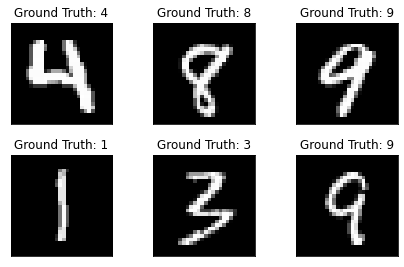

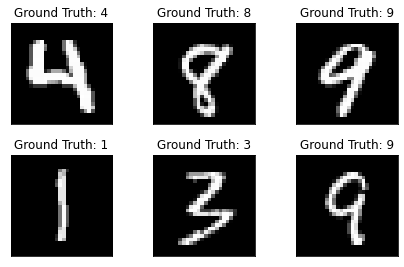

In [3]:
# Показываем примеры вместе с ответом
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [4]:
# Фиксируем глобальные параметры
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
# Создаем переменные нужные для обучения

model = Net()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [7]:
def train(epoch):
  model.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.cuda()
    target = target.cuda()

    optimizer.zero_grad()
    output = model(data)
    
    loss = F.nll_loss(output, target)
    loss.backward()
    
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

def test():
  model.eval()

  test_loss = 0
  correct = 0
  
  with torch.no_grad():
    for data, target in test_loader:
      data = data.cuda()
      target = target.cuda()

      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [8]:
%%time
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3316, Accuracy: 1137/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323282
Train Epoch: 1 [100/60000 (0%)]	Loss: 2.336207
Train Epoch: 1 [200/60000 (0%)]	Loss: 2.336110
Train Epoch: 1 [300/60000 (0%)]	Loss: 2.210843
Train Epoch: 1 [400/60000 (1%)]	Loss: 2.297603
Train Epoch: 1 [500/60000 (1%)]	Loss: 2.222815
Train Epoch: 1 [600/60000 (1%)]	Loss: 2.297561
Train Epoch: 1 [700/60000 (1%)]	Loss: 2.056468
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.269234
Train Epoch: 1 [900/60000 (2%)]	Loss: 1.905675
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.105371
Train Epoch: 1 [1100/60000 (2%)]	Loss: 1.842342
Train Epoch: 1 [1200/60000 (2%)]	Loss: 1.873234
Train Epoch: 1 [1300/60000 (2%)]	Loss: 1.916723
Train Epoch: 1 [1400/60000 (2%)]	Loss: 1.580489
Train Epoch: 1 [1500/60000 (2%)]	Loss: 1.659993
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.692244
Train Epoch: 1 [1700/60000 (3%)]	Loss: 1.550766
Train Epoch: 1 [1800/60000 (3%)]	Loss: 1.332738
Train Epoch: 1 [1900/60000 (3%)]	Loss: 1.3

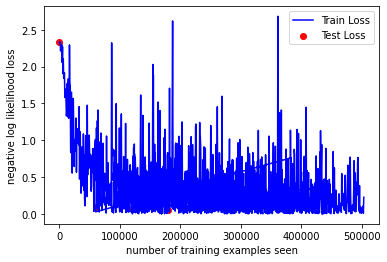

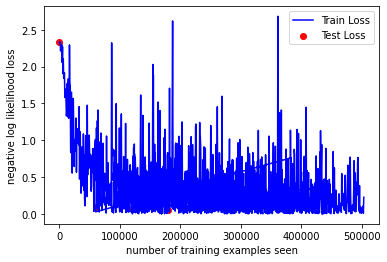

In [9]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


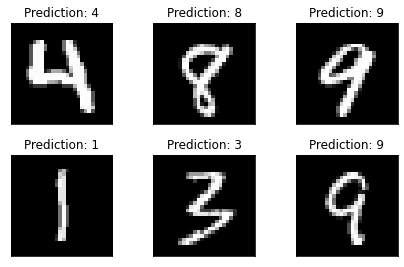

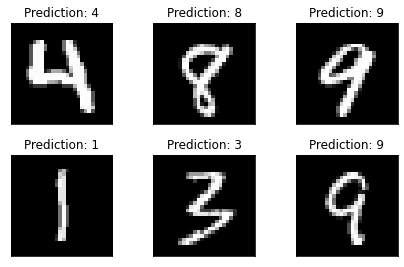

In [10]:
with torch.no_grad():
  output = model(example_data.cuda())

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [11]:
test_loss_min = 0
bad_data = []
output_for_data = []
target_for_data = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data.cuda())
        test_loss = F.nll_loss(output, target.cuda(), size_average=False).item()

        for i in range(len(target)):
            if target[i] != output.data.max(1, keepdim=True)[1][i].item():
                bad_data.append(data[i][0])
                target_for_data.append(target[i])
                output_for_data.append(output.data.max(1, keepdim=True)[1][i].item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


<Figure size 432x288 with 0 Axes>

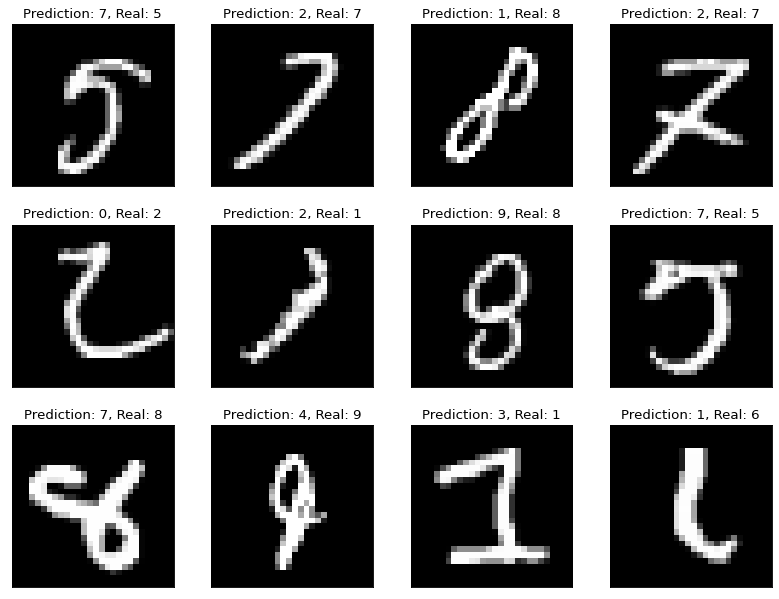

In [12]:
fig = plt.figure()
plt.figure(figsize=(10, 8), dpi=80)
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(bad_data[i], cmap='gray', interpolation='none')
  plt.title("Prediction: {}, Real: {}".format(output_for_data[i], target_for_data[i]))
  plt.xticks([])
  plt.yticks([])